In [1]:
# !pip install transformers tokenizers datasets
# !pip install torchvision 

In [1]:
import tensorflow as tf
import glob
import os
import shutil
import tqdm
import random
import matplotlib.pyplot as plt
import torch
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from transformers import PreTrainedTokenizerFast    
from transformers import DataCollatorForLanguageModeling
from transformers import GPT2Config, GPT2LMHeadModel
from transformers import TrainingArguments, Trainer

tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
# !del lovecraftcorpus

In [3]:
dataset_file = "dataset.txt"

# How many files to load.
file_number = 100

# Clone the repo.
!git clone https://github.com/vilmibm/lovecraftcorpus
    
# Find all the files.
paths = glob.glob("lovecraftcorpus/*.txt")

# Do not use all.
paths = paths[:file_number]
print(sorted(paths))

# Merge.
with open(dataset_file, "w") as output_file:
    for path in paths:
        for line in open(path, "r"):
            for split in line.split("\n"):
                split = split.strip()
                if split != "":
                    print(split, file=output_file)

# Delete repo.
# !del -rf lovecraftcorpus

# Done.
print("Corpus downloaded.")

['lovecraftcorpus\\alchemist.txt', 'lovecraftcorpus\\arthur_jermyn.txt', 'lovecraftcorpus\\azathoth.txt', 'lovecraftcorpus\\beast.txt', 'lovecraftcorpus\\beyond_wall_of_sleep.txt', 'lovecraftcorpus\\book.txt', 'lovecraftcorpus\\celephais.txt', 'lovecraftcorpus\\charles_dexter_ward.txt', 'lovecraftcorpus\\clergyman.txt', 'lovecraftcorpus\\colour_out_of_space.txt', 'lovecraftcorpus\\cool_air.txt', 'lovecraftcorpus\\crawling_chaos.txt', 'lovecraftcorpus\\cthulhu.txt', 'lovecraftcorpus\\dagon.txt', 'lovecraftcorpus\\descendent.txt', 'lovecraftcorpus\\doorstep.txt', 'lovecraftcorpus\\dreams_in_the_witch.txt', 'lovecraftcorpus\\dunwich.txt', 'lovecraftcorpus\\erich_zann.txt', 'lovecraftcorpus\\ex_oblivione.txt', 'lovecraftcorpus\\festival.txt', 'lovecraftcorpus\\from_beyond.txt', 'lovecraftcorpus\\gates_of_silver_key.txt', 'lovecraftcorpus\\haunter.txt', 'lovecraftcorpus\\he.txt', 'lovecraftcorpus\\high_house_mist.txt', 'lovecraftcorpus\\hound.txt', 'lovecraftcorpus\\hypnos.txt', 'lovecraftc

fatal: destination path 'lovecraftcorpus' already exists and is not an empty directory.


In [4]:
raw_datasets = load_dataset("text", data_files=[dataset_file])
raw_datasets

Using custom data configuration default-f21f4c24bd3404c2


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset text downloaded and prepared to C:/Users/DAnand/.cache/huggingface/datasets/text/default-f21f4c24bd3404c2/0.0.0/21a506d1b2b34316b1e82d0bd79066905d846e5d7e619823c0dd338d6f1fa6ad. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 4371
    })
})

In [5]:
raw_datasets["train"]
# [index]["text"]

Dataset({
    features: ['text'],
    num_rows: 4371
})

In [6]:
for index in range(10):
  token_sequence = raw_datasets["train"][index]["text"]
  print(token_sequence)


THE ALCHEMIST
High up, crowning the grassy summit of a swelling mount whose sides are wooded near the base with the gnarled trees of the primeval forest stands the old chateau of my ancestors. For centuries its lofty battlements have frowned down upon the wild and rugged countryside about, serving as a home and stronghold for the proud house whose honored line is older even than the moss-grown castle walls. These ancient turrets, stained by the storms of generations and crumbling under the slow yet mighty pressure of time, formed in the ages of feudalism one of the most dreaded and formidable fortresses in all France. From its machicolated parapets and mounted battlements Barons, Counts, and even Kings had been defied, yet never had its spacious halls resounded to the footsteps of the invader.
But since those glorious years, all is changed. A poverty but little above the level of dire want, together with a pride of name that forbids its alleviation by the pursuits of commercial life, h

In [7]:
tokenizer = Tokenizer(BPE(unk_token="[UNK]")) #Byte pair encoding
trainer = BpeTrainer(vocab_size=5000, special_tokens=["[UNK]", "[PAD]"])  # type: ignore
tokenizer.pre_tokenizer = Whitespace()

def batch_iterator(batch_size=1000):
    for i in range(0, len(raw_datasets["train"]), batch_size):
        yield raw_datasets["train"][i:i + batch_size]["text"]

tokenizer.train_from_iterator(
    batch_iterator(),
    trainer=trainer,
    length=len(raw_datasets["train"])
)

tokenizer.save("tokenizer.json")

tokenizer = PreTrainedTokenizerFast(tokenizer_file="tokenizer.json")
tokenizer.add_special_tokens({"pad_token":"[PAD]"})

0

In [8]:
print(tokenizer.vocab_size)
print(tokenizer.vocab)

5000
{'ening': 1265, 'stup': 2797, 'sem': 1266, 'understand': 3021, 'kets': 3977, 'fle': 910, 'suc': 1528, 'admir': 4853, 'dith': 4893, 'wind': 412, 'jagged': 4148, 'howling': 4894, 'een': 3478, 'nu': 4151, 'ified': 1765, 'u': 73, 'Le': 1943, 'vil': 3307, 'spaces': 3804, 'paint': 3143, 'inter': 746, 'then': 547, 'spect': 926, 'stuff': 3931, 'pap': 1292, 'aut': 1215, 've': 131, 'en': 99, 'crow': 2043, 'dif': 908, 'Out': 2741, 'prison': 2975, 'nod': 3719, 'cottage': 3850, 'absor': 4539, 'clearly': 2131, 'grandmother': 4669, 'No': 1004, 'antic': 991, 'members': 3918, 'ys': 804, 'omed': 1494, 'hum': 2623, 'signs': 2129, 'awaked': 4740, 'Rand': 1773, 'spite': 4745, 'utmost': 4865, 'ging': 1283, 'eye': 1901, 'well': 473, 'writ': 1137, 'uded': 2271, 'vel': 788, 'inexplic': 2837, 'rope': 3571, 'merchants': 4089, 'frantically': 4103, 'sport': 2471, 'vainly': 4328, 'songs': 4555, 'naturally': 4638, 'ne': 168, 'glow': 2937, 'psy': 2500, 'IV': 4697, 'claw': 2351, 'remaining': 4670, 'nether': 4736,

In [9]:
token_sequence = raw_datasets["train"][3]["text"]
print(token_sequence)

token_indices = tokenizer(token_sequence)["input_ids"]
print(token_indices)


tokens = [tokenizer.decode([index]) for index in token_indices]
print(tokens)


It was in one of the vast and gloomy chambers of this remaining tower that I, Antoine, last of the unhappy and accursed Counts de C-, first saw the light of day, ninety long years ago. Within these walls and amongst the dark and shadowy forests, the wild ravines and grottos of the hillside below, were spent the first years of my troubled life. My parents I never knew. My father had been killed at the age of thirty--two, a month before I was born, by the fall of a stone somehow dislodged from one of the deserted parapets of the castle. And my mother having died at my birth, my care and education devolved solely upon one remaining servitor, an old and trusted man of considerable intelligence, whose name I remember as Pierre. I was an only child and the lack of companionship which this fact entailed upon me was augmented by the strange care exercised by my aged guardian, in excluding me from the society of the peasant children whose abodes were scattered here and there upon the plains tha

100%|██████████| 4371/4371 [00:02<00:00, 2149.14it/s]


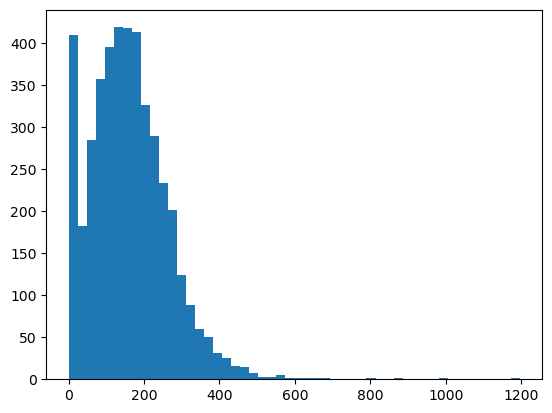

In [10]:
lengths = []
for token_sequence in tqdm.tqdm(raw_datasets["train"]):
    token_sequence = token_sequence["text"]
    token_indices = tokenizer(token_sequence)["input_ids"]
    lengths += [len(token_indices)]

plt.hist(lengths, bins = 50)
plt.show()

In [11]:
sequence_length = 256

def tokenize_function(example):
    tokenized_example = tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=sequence_length
    )  # type: ignore
    return {
        "input_ids": tokenized_example["input_ids"]
    }

token_sequence = raw_datasets["train"][0]
print(token_sequence)

tokenized = tokenize_function(token_sequence)
print(tokenized)

{'text': 'THE ALCHEMIST'}
{'input_ids': [2285, 27, 38, 29, 34, 31, 39, 35, 45, 46, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [12]:
tokenized_datasets = raw_datasets.map(
    tokenize_function,
    batched=True,
    remove_columns=raw_datasets["train"].column_names
)

tokenized = tokenized_datasets["train"][0]
print(tokenized)

  0%|          | 0/5 [00:00<?, ?ba/s]

{'input_ids': [2285, 27, 38, 29, 34, 31, 39, 35, 45, 46, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [13]:
data_collector = DataCollatorForLanguageModeling(tokenizer, mlm=False)

In [14]:
model_config = GPT2Config(
    vocab_size=tokenizer.vocab_size,
    pad_token_id=tokenizer.pad_token_id,
    n_ctx=sequence_length,
    n_positions=sequence_length,
    n_head=8,
    n_layers=9,
    n_embd=512
)

model = GPT2LMHeadModel(model_config)
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(5000, 512)
    (wpe): Embedding(256, 512)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropo

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


input_ids: tensor([[ 528,  622,  383,  308,  105,  272,  633,    9,  156,  114, 1964,   11,
           27,  216,  142,  494,  195,  635,  706,   93, 1690,  103,  980, 3199,
            9, 1341,  152,   53,  309,  253,  103,  704,  128, 1829,   71,  282,
          108,  117, 1026,  223,  213,   93, 2088,  282,  103,  293,  658, 1514,
          615,    9,  233, 4514,   96,   93,  247,  331,  103,  201,  867,  187,
         1996,  287,  107,  290,  343, 1424,   92,  940,  104,  375, 3348,  201,
           24,  102,   93, 3395, 1523,  103,   93,  874,    9,   93,  319, 2188,
         3533,   92,   93,   68,  327,   71,    9,   93, 3420,  102, 1733,   77,
          160,  100,    9,   93,  215,   10,   68, 1971,  583,  494, 1511,    9,
          102, 1277,  206,  107, 2240,  687,    9,  109,  473,  109,   93,   71,
          158, 1283,  568,  652,    9,   93,  281,   65,   10, 4703,   75,  163,
          247, 3787,    9,  102,   93, 4704,   72,  935, 1880,  110, 1180,    9,
          156,  6

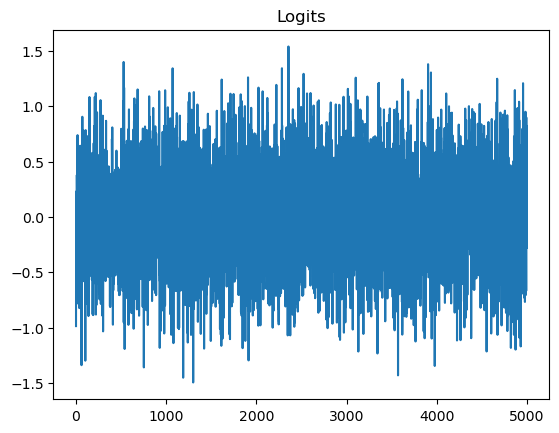

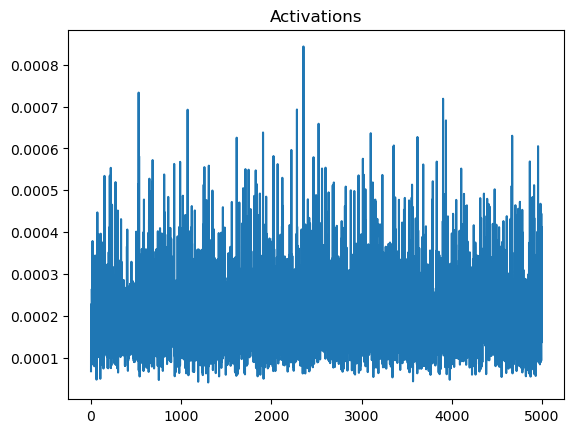

In [15]:
inputs = [tokenized_datasets["train"][2]]
inputs = data_collector(inputs)
assert list(inputs.keys()) == ["input_ids", "attention_mask", "labels"], list(inputs.keys())
print("input_ids:", inputs["input_ids"])
print("")

outputs = model(**inputs)
assert list(outputs.keys()) == ["loss", "logits", "past_key_values"], list(outputs.keys())
print("logits:", outputs["logits"])

plt.plot(outputs["logits"].detach().numpy()[0][0])
plt.title("Logits")
plt.show()
plt.close()

activations = torch.nn.functional.softmax(outputs["logits"], dim=-1)
plt.plot(activations.detach().numpy()[0][0])
plt.title("Activations")
plt.show()
plt.close()